# model with *compressed* NMF basis SFH
I've implemented a SPS model that uses NMF SFH and ZH bases. However, rather than having the bases cut off at $t_{\rm age}$, the basis is compressed to fit $0 - t_{\rm age}$. I want to see whether this relaxes the priors on ${\rm SSFR}$ and $Z_{\rm MW}$ or reduces the redshift dependence of the priors. 

In [1]:
import numpy as np 
from provabgs import infer as Infer
from provabgs import models as Models

In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
fsps = Models.FSPS(name='nmf_comp')

In [4]:
t, sfh1 = fsps.SFH(np.array([0., 1., 0., 0., 0.]), 0.1)
_, sfh2 = fsps.SFH(np.array([0., 0., 1., 0., 0.]), 0.1)
_, sfh3 = fsps.SFH(np.array([0., 0., 0., 1., 0.]), 0.1)
_, sfh4 = fsps.SFH(np.array([0., 0., 0., 0., 1.]), 0.1)

(0.0, 0.3710161430001133)

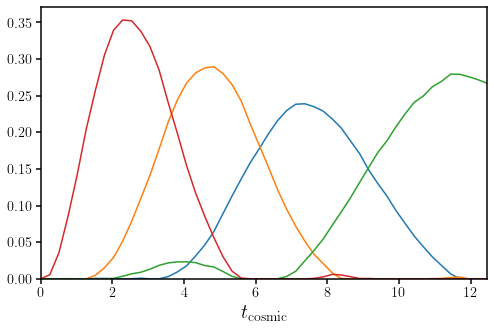

In [5]:
fig = plt.figure(figsize=(8,5))
sub = fig.add_subplot(111)
sub.plot(t, sfh1)
sub.plot(t, sfh2)
sub.plot(t, sfh3)
sub.plot(t, sfh4)
sub.set_xlabel(r'$t_{\rm cosmic}$', fontsize=20)
sub.set_xlim(0., t.max())
sub.set_ylim(0., None)

(0.0, 0.4093306601692585)

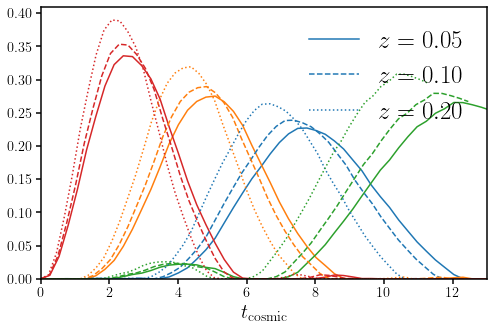

In [6]:
fig = plt.figure(figsize=(8,5))
sub = fig.add_subplot(111)
for zred, ls in zip([0.05, 0.1, 0.2], ['-', '--', ':']): 
    t, sfh1 = fsps.SFH(np.array([0., 1., 0., 0., 0.]), zred)
    _, sfh2 = fsps.SFH(np.array([0., 0., 1., 0., 0.]), zred)
    _, sfh3 = fsps.SFH(np.array([0., 0., 0., 1., 0.]), zred)
    _, sfh4 = fsps.SFH(np.array([0., 0., 0., 0., 1.]), zred)

    sub.plot(t, sfh1, c='C0', ls=ls, label='$z=%.2f$' % zred)
    sub.plot(t, sfh2, c='C1', ls=ls)
    sub.plot(t, sfh3, c='C2', ls=ls)
    sub.plot(t, sfh4, c='C3', ls=ls)
sub.legend(loc='upper right', fontsize=25)
sub.set_xlabel(r'$t_{\rm cosmic}$', fontsize=20)
sub.set_xlim(0., 13)
sub.set_ylim(0., None)

Figure above illustrates how the SFH bases are compressed for galaxies at higher redshift. 

In [7]:
np.random.seed(0)
prior_tau = Infer.load_priors([
    Infer.UniformPrior(0., 0., label='sed'), 
    Infer.FlatDirichletPrior(4, label='sed'), 
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed')      # uniform priors on dust_index 
])

In [8]:
n_sample = 50000

In [9]:
thetas = np.array([prior_tau.sample() for i in range(n_sample)])

In [10]:
logSSFR_100myr = np.log10(fsps.avgSFR(thetas, zred, dt=0.1)) - thetas[:,0]
logSSFR_1gyr = np.log10(fsps.avgSFR(thetas, zred, dt=1.)) - thetas[:,0]
logZmw = np.log10(fsps.Z_MW(thetas, zred))

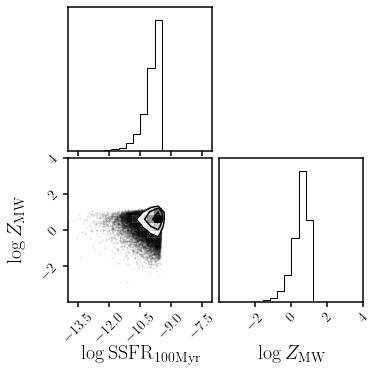

In [11]:
fig = DFM.corner(
    np.array([logSSFR_100myr, logZmw]).T, 
    range=[(-14, -7), [-4., 4]], 
    labels=[r'$\log {\rm SSFR}_{\rm 100 Myr}$', r'$\log Z_{\rm MW}$'], 
    label_kwargs={'fontsize': 20})

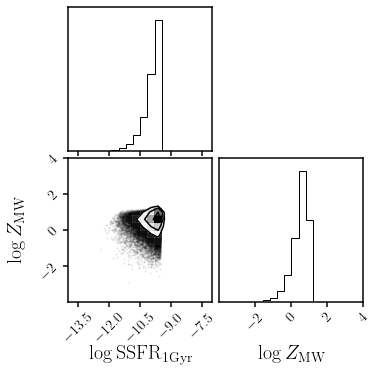

In [12]:
fig = DFM.corner(
    np.array([logSSFR_1gyr, logZmw]).T, 
    range=[(-14, -7), [-4., 4]], 
    labels=[r'$\log {\rm SSFR}_{\rm 1 Gyr}$', r'$\log Z_{\rm MW}$'], 
    label_kwargs={'fontsize': 20})

As expected, there isn't a substantial difference in the prior imposed on ${\rm SSFR}$ and $Z_{\rm MW}$. Lets see if the redshift dependence has changed.

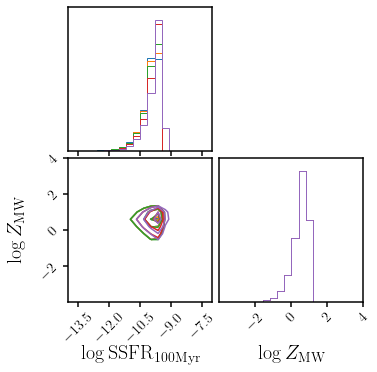

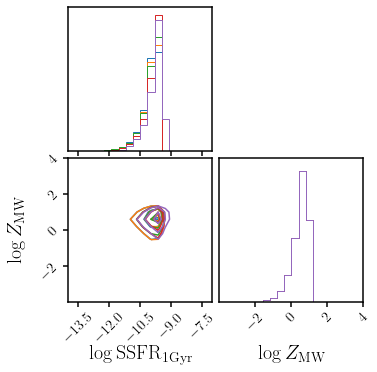

In [13]:
fig1, fig2 = None, None

for i, zred in enumerate([0.01, 0.05, 0.1, 0.25, 0.5]):     
    logSSFR_100myr = np.log10(fsps.avgSFR(thetas, zred, dt=0.1))
    logSSFR_1gyr = np.log10(fsps.avgSFR(thetas, zred, dt=1.))
    logZmw = np.log10(fsps.Z_MW(thetas, zred))
    
    fig1 = DFM.corner(
        np.array([logSSFR_100myr, logZmw]).T, 
        range=[(-14, -7), [-4., 4]], 
        labels=[r'$\log {\rm SSFR}_{\rm 100 Myr}$', r'$\log Z_{\rm MW}$'], 
        label_kwargs={'fontsize': 20}, 
        color='C%i' % i,
        plot_density=False,
        plot_datapoints=False,         
        fig=fig1)
    
    fig2 = DFM.corner(
        np.array([logSSFR_1gyr, logZmw]).T, 
        range=[(-14, -7), [-4., 4]], 
        labels=[r'$\log {\rm SSFR}_{\rm 1 Gyr}$', r'$\log Z_{\rm MW}$'], 
        label_kwargs={'fontsize': 20},
        color='C%i' % i,
        plot_density=False,
        plot_datapoints=False, 
        fig=fig2)

Yes, with the compressed NMF bases, the priors are less dependent on the redshift. But overall the priors are still more restrictive than the $\tau$ model